# Testing the effect integration length has on Lyapunov Analysis

## Imports

In [7]:
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, prange

## Data Space

In [21]:
N     = 256
k0    = 1
alpha = np.array([1.4]) #np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.49])
beta  = 0.0;
u0    = "TEST"
m_end = ( 40000, 20000, 12500, 10000, 8000)
m_itr = ( 10, 20, 32, 40, 50)
# m_end = (100000, 10000, 5000, 3125, 2500, 2000)
# m_itr = (1, 10, 20, 32, 40, 50)
# iters = m_end * m_itr
trans = 0
# trans_iters = np.array([0, 10, 100, 1000, 10000, 20000, 50000])

## Folders

In [22]:
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Test"

## Function Definitions

In [23]:
@njit
def compute_lce(rnorm, time, iters, dof, trans):
    
    run_sum = np.zeros((dof))
    lce_py  = np.zeros((iters - trans, dof))
    
    ## Loop over time and compute lce
    for t in range(trans, iters + 1):
        
        if t > trans:
            for n in range(dof):
                run_sum[n]   += np.log(rnorm[t - 1, n])
                lce_py[t - (trans + 1), n] = run_sum[n] / (time[t] - time[trans])
                          
    return lce_py[-1, :]

@njit
def compute_dim(lce, dof):
    k = 1
    for n in range(dof):
        while np.cumsum(lce[:n]) > 0:
            k += 1
        else:
            break
            
    return k + np.cumsum(lce[:k]) / np.absolute(lce[k])

@njit
def compute_zdata(clv, num_tsteps, dof):
    
    z_data   = np.zeros((dof, dof))
    
    for t in range(num_tsteps):
        z_data += np.square(clv[t, :, :])
    
    z_data = z_data / num_tsteps
    
    return z_data

@njit
def compute_angles(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                angles[t, i, j] = np.arccos(np.absolute(np.dot(CLV[t, :, i], CLV[t, :, j])))
    
    return angles


def compute_angles_subspaces(A1, B1, num_clv_steps):
    
    angles1 = np.zeros((num_clv_steps))
    
    for t in range(num_clv_steps):
        angles1[t] = subspace_angles(A1[t, :, :], B1[t, :, :])[0]
        
    return angles1

## Loop Through the Data

In [24]:
dim      = np.zeros((alpha.shape[0], len(m_end)))
lce      = np.zeros((int(N/2 - 1), alpha.shape[0], len(m_end)))
are_nans = np.zeros((alpha.shape[0], len(m_end)))

In [25]:
for i, a in enumerate(alpha):
    for j, (m_e, m_i) in enumerate(zip(m_end, m_itr)):
        
        print(a, m_e, m_i)

        ## Create filename from data
        filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/CLVData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, m_e * m_i, m_e, m_i)

        ## Check if file exists and open
        if os.path.exists(filename + "_TRANS[{}].h5".format(trans)):
            HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans), 'r')

        ## Read in data
        # rnorm     = HDFfileData['RNorm'][:, :]
        CLVs   = HDFfileData['CLVs']
        angles = HDFfileData['Angles']
        lce[:, i, j] = HDFfileData['LCE'][-1, :]
        
        ## Compute needed parameters
        dof = lce.shape[0]

        ## Reshape the CLV and Angles data
        clv_dims = CLVs.attrs['CLV_Dims']
        CLV      = np.reshape(CLVs, (CLVs.shape[0], dof, dof))
        ang_dims = angles.attrs['Angle_Dims']
        angle    = np.reshape(angles, (angles.shape[0], dof, dof))
        
        ## Check if NaNs present
        are_nans[i, j] = np.sum(np.isnan(angle))
    
        ## Compute Dim
        dim[i, j] = compute_dim(lce[:, i, j], dof)

        ## Close file 
        HDFfileData.close()

1.4 40000 10
1.4 20000 20
1.4 12500 32
1.4 10000 40
1.4 8000 50


In [26]:
print(are_nans)

[[0. 0. 0. 0. 0.]]


/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


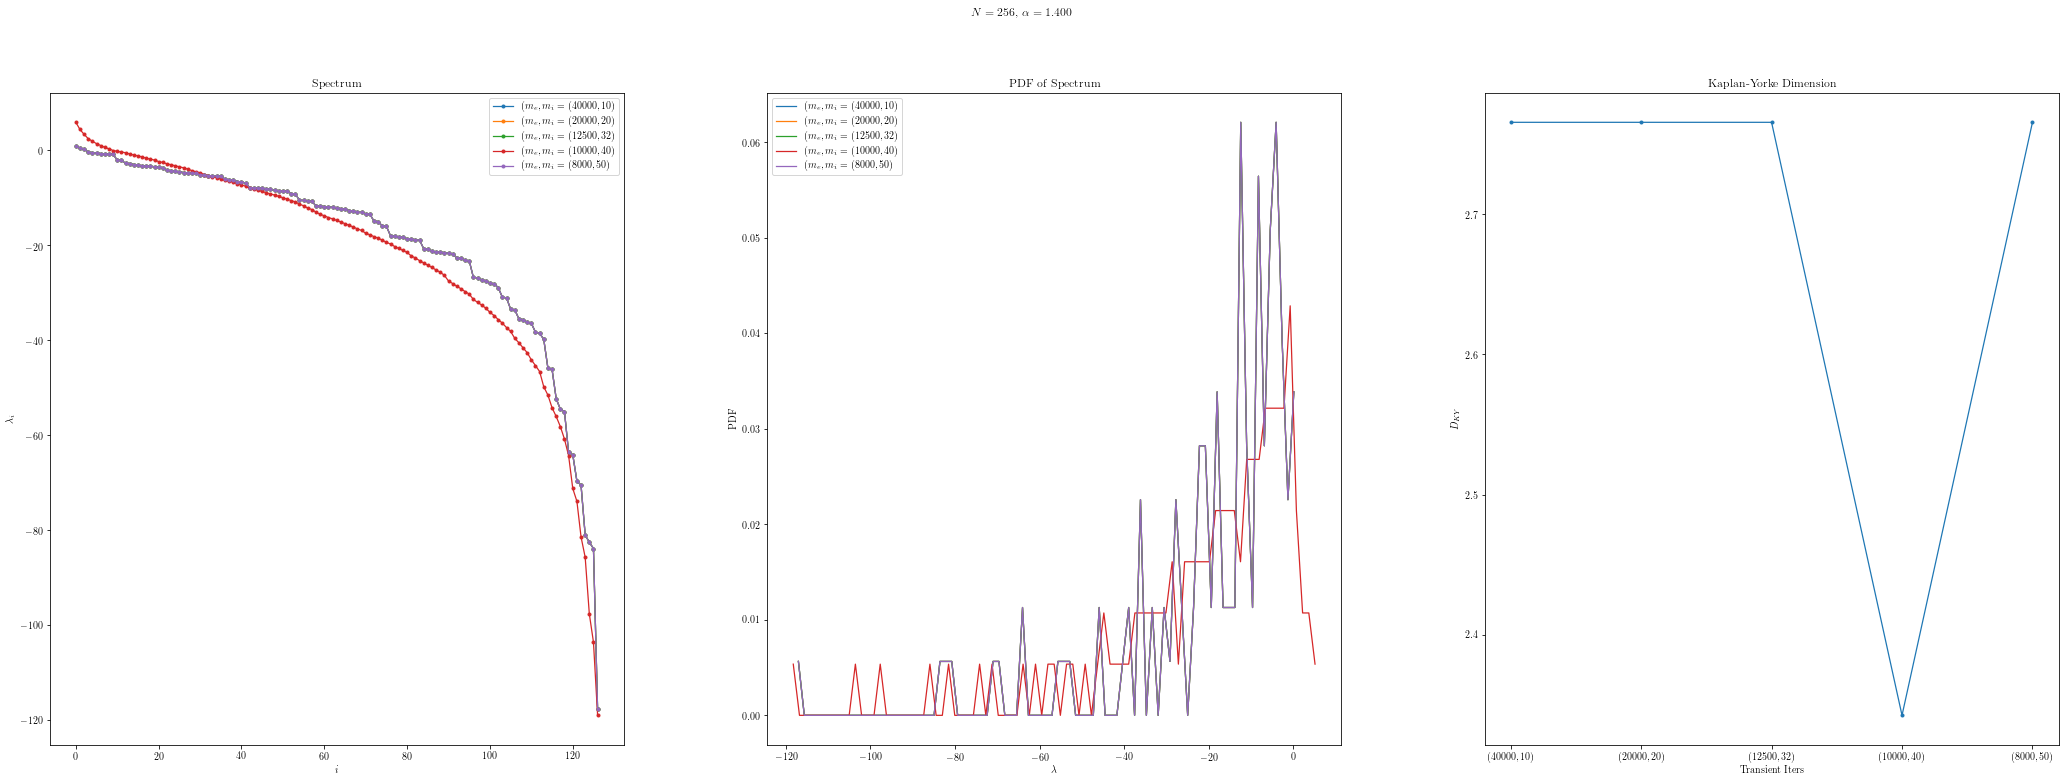

In [29]:
for j, a in enumerate(alpha):
 
    ## Create figure
    fig = plt.figure(figsize = (36, 12), tight_layout = True)
    gs  = GridSpec(1, 3, wspace = 0.25)

    ## Spectrum
    ax1 = fig.add_subplot(gs[0, 0])
    for i, (m_e, m_i) in enumerate(zip(m_end, m_itr)):
        ax1.plot(lce[:, j, i], '.-')
        ax1.set_xlabel(r"$i$")
        ax1.set_ylabel(r"$\lambda_i$")
    ax1.legend([r"$(m_e, m_i = ({}, {})$".format(m_e, m_i) for m_e, m_i in zip(m_end, m_itr)])
    ax1.set_title(r"Spectrum")

#     ## PDF
    ax2 = fig.add_subplot(gs[0, 1])
    for i, (m_e, m_i) in enumerate(zip(m_end, m_itr)):
        hist, bins  = np.histogram(lce[:, j, i], bins = int(N / 3), density = True);
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        ax2.plot(bin_centers, hist)
        ax2.set_xlabel(r"\lambda")
        ax2.set_ylabel(r"PDF")
    ax2.legend([r"$(m_e, m_i = ({}, {})$".format(m_e, m_i) for m_e, m_i in zip(m_end, m_itr)])
    ax2.set_title(r"PDF of Spectrum")

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(dim[j, :], '.-')
    ax3.set_xlabel(r"Transient Iters")
    ax3.set_xticks([i for i in range(len(m_end))])
    ax3.set_xticklabels([r"$({}, {})$".format(m_e, m_i) for m_e, m_i in zip(m_end, m_itr)])
    ax3.set_ylabel(r"$D_{KY}$")
    ax3.set_title(r"Kaplan-Yorke Dimension")

    plt.suptitle(r"$N = {}$, $\alpha = {:0.3f}$".format(N, a))
    
    plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Test" + "/IntegrationLength_LCEs_N[{}]_ALPHA[{:0.3f}].png".format(N, a), format = "png") 
    plt.show()